In [1]:
import geopandas as gpd
import os

os.chdir('../..')
nearmap_tile = "/Users/adamswietek/Downloads/USC_Nearmap_Sample_Data/IMAGERY_SAMPLE_EPSG3857_Date20251005/Tiles.shp"
nearmap_building = '/Users/adamswietek/Downloads/USC_Nearmap_Sample_Data/AI_SAMPLE/ai_features_None_Building.gpkg'
nearmap_building = gpd.read_file(nearmap_building)
nearmap_tile = gpd.read_file(nearmap_tile)


In [2]:
import glob, re

nearmap_ai_dir = '/Users/adamswietek/Downloads/USC_Nearmap_Sample_Data/AI_SAMPLE'

layer_files = sorted(glob.glob(f'{nearmap_ai_dir}/ai_features_None_*.gpkg'))
skip = re.compile(r'_Building.*|_Deprecated.*', re.IGNORECASE)
layer_files = [f for f in layer_files if not skip.search(os.path.basename(f))]

def layer_name(path):
    """ai_features_None_Roof_Rusting.gpkg  →  roof_rusting"""
    name = os.path.basename(path).replace('ai_features_None_', '').replace('.gpkg', '')
    return name.lower().replace('-', '_')

ai_cols = [layer_name(f) for f in layer_files]
print(f"Found {len(layer_files)} AI layers to process in Step 5:")
for col in ai_cols:
    print(f"  {col}")

Found 20 AI layers to process in Step 5:
  dormer_window
  dutch_gable
  flat
  gable
  hip
  leaf_off_tree_overhang
  metal
  missing_roof_tile_or_shingle
  roof
  roof_ponding
  roof_rusting
  roof_with_permanent_repair
  roof_with_temporary_repair
  shingle
  structural_damage
  tile
  tile_or_shingle_staining
  tree_overhang
  turret
  zinc_staining


In [ ]:
from src.geoadmin import load_laraic, get_landbase_bymask, load_assessor_parcels_bygeom

LANDBASE_YR = 2020
ASSESSOR_YR = 2020
LARIAC_YR   = 2020

def load_data_by_year(neighborhood, lb_yr, apd_yr, lar_yr, source='lariac'):
    landbase_parcels = get_landbase_bymask(neighborhood, lb_yr)

    polygon_geometry = neighborhood.to_crs(4326).iloc[0].geometry
    assessor_data = load_assessor_parcels_bygeom(polygon_geometry)
    assessor_data = assessor_data.loc[assessor_data.RollYear == apd_yr]
    assessor_data = assessor_data.to_crs(landbase_parcels.crs)

    if source == 'lariac':
        lariac_structures = load_laraic(neighborhood, lar_yr)
        lariac_structures = lariac_structures.to_crs(landbase_parcels.crs)

    return landbase_parcels, assessor_data, lariac_structures

landbase, assessor, lariac = load_data_by_year(
    nearmap_tile.dissolve(), lb_yr=LANDBASE_YR, apd_yr=ASSESSOR_YR, lar_yr=LARIAC_YR)

landbase2, assessor2, lariac2 = load_data_by_year(
    nearmap_tile.dissolve(), lb_yr=2016, apd_yr=2020, lar_yr=2014)

ERROR 1: PROJ: internal_proj_identify: /Users/adamswietek/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /Users/adamswietek/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /Users/adamswietek/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /Users/adamswietek/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
/opt/homebrew/Caskroom/miniforge/base/envs/samgeo/lib/python3.12/site-packages/pyogrio/core.py:280: UserWarning: Measured (M) geometry types are not supported. 

In [31]:
lb   = landbase[['ASSETID', 'geometry']].copy()
asr  = assessor.copy()
asr2 = assessor2.copy()
lar  = lariac.dropna(subset=['HEIGHT'])[['BLD_ID', 'AREA', 'geometry']].copy()

# Reproject Nearmap buildings to match landbase CRS (EPSG:2229, NAD83 California zone 5 ftUS)
# Offset correction and nm slice happen below — everything uses the projected geometry from here on
nm_proj = nearmap_building[['id', 'areaSqft', 'clippedAreaSqft', 'geometry']].copy().to_crs(lb.crs)
print(f"nm_proj: {len(nm_proj):,} buildings  |  CRS: {nm_proj.crs}")

nm_proj: 5,321 buildings  |  CRS: EPSG:2229


In [32]:
from shapely.affinity import translate
from sklearn.neighbors import BallTree
import numpy as np

# Nearest-neighbour centroid matching between nm buildings and parcels
# to estimate the systematic spatial shift
lb_xy = np.column_stack([lb.geometry.centroid.x, lb.geometry.centroid.y])
nm_xy = np.column_stack([nm_proj.geometry.centroid.x, nm_proj.geometry.centroid.y])

tree = BallTree(lb_xy)
dist, idx = tree.query(nm_xy, k=1)

mask = dist[:, 0] < 200  # only use close pairs (within 200 ft)
dx = lb_xy[idx[mask, 0], 0] - nm_xy[mask, 0]
dy = lb_xy[idx[mask, 0], 1] - nm_xy[mask, 1]

print(f"Pairs used: {mask.sum()}")
print(f"  dx  mean={dx.mean():.2f} ft   median={np.median(dx):.2f} ft   std={dx.std():.2f} ft")
print(f"  dy  mean={dy.mean():.2f} ft   median={np.median(dy):.2f} ft   std={dy.std():.2f} ft")

# This offset is applied to nm_proj AND all AI layers in Step 5
OFFSET_X = float(np.median(dx))
OFFSET_Y = float(np.median(dy))
print(f"\nOFFSET_X = {OFFSET_X:.2f} ft  |  OFFSET_Y = {OFFSET_Y:.2f} ft  (applied to all layers)")

Pairs used: 5320
  dx  mean=4.78 ft   median=7.88 ft   std=14.68 ft
  dy  mean=-1.75 ft   median=-1.66 ft   std=32.55 ft

OFFSET_X = 7.88 ft  |  OFFSET_Y = -1.66 ft  (applied to all layers)


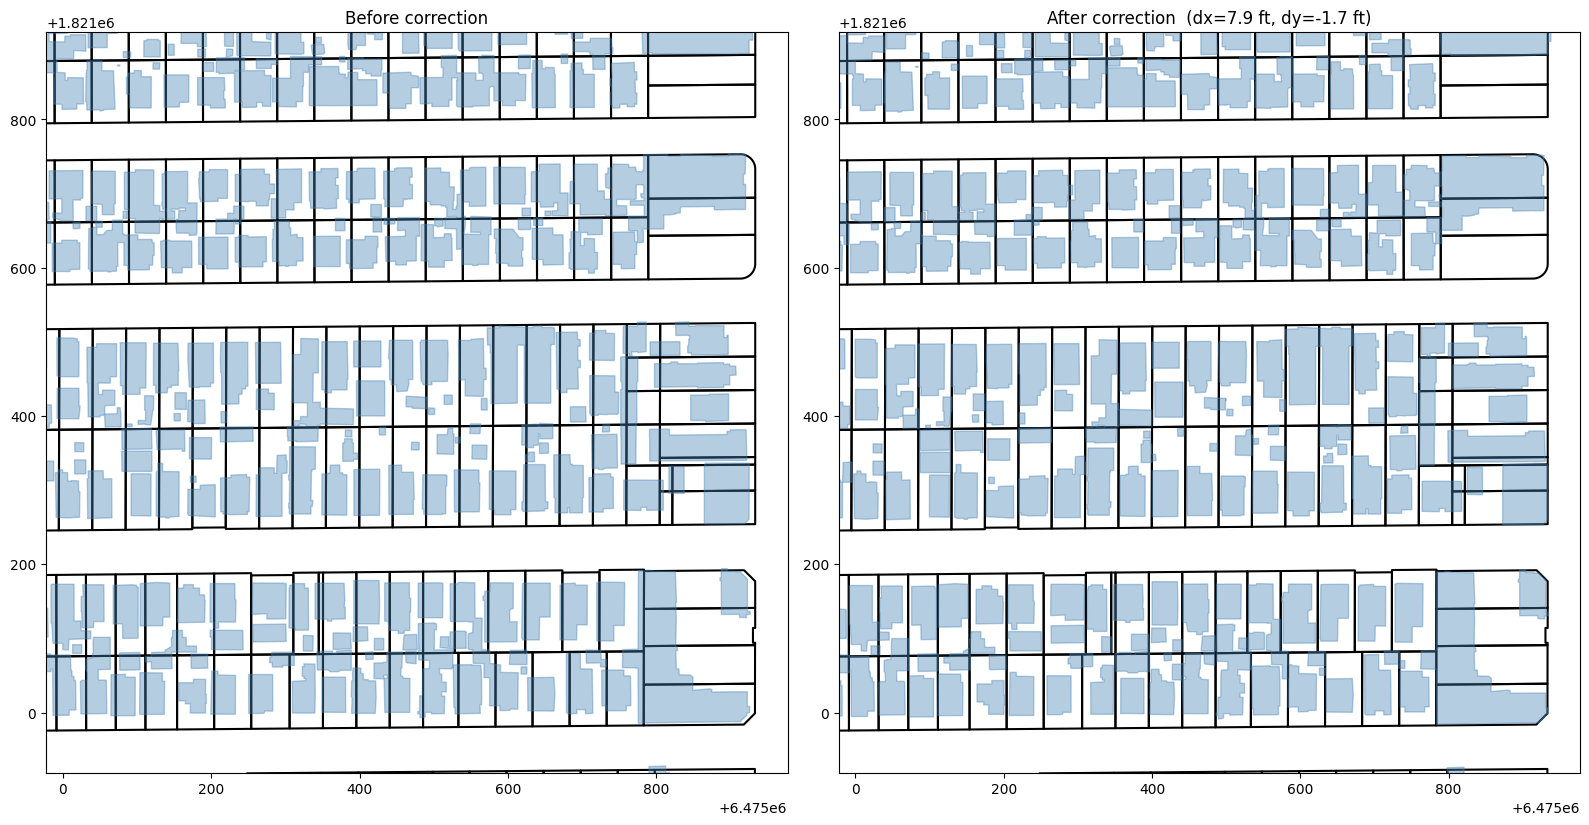

nm_aligned ready — same offset will be applied to all AI layers in Step 5.


In [33]:
import matplotlib.pyplot as plt

# Zoom into a small area to inspect the offset more closely
sample_pt = nm_proj.geometry.iloc[0].centroid
buf = 500  # ft
xmin, ymin, xmax, ymax = sample_pt.x-buf, sample_pt.y-buf, sample_pt.x+buf, sample_pt.y+buf

lb_clip = lb.cx[xmin:xmax, ymin:ymax]
nm_clip = nm_proj.cx[xmin:xmax, ymin:ymax]


# Apply translation to nm buildings and show before/after
nm_aligned = nm_proj.copy()
nm_aligned.geometry = nm_aligned.geometry.translate(xoff=OFFSET_X, yoff=OFFSET_Y)

nm_clip_aligned = nm_aligned.cx[xmin:xmax, ymin:ymax]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
for ax, nm_plot, title in zip(
    axes,
    [nm_clip, nm_clip_aligned],
    ['Before correction', f'After correction  (dx={OFFSET_X:.1f} ft, dy={OFFSET_Y:.1f} ft)']
):
    lb_clip.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.5)
    nm_plot.plot(ax=ax, facecolor='steelblue', alpha=0.4, edgecolor='steelblue', linewidth=1)
    ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
    ax.set_title(title)
plt.tight_layout()
plt.show()
print("nm_aligned ready — same offset will be applied to all AI layers in Step 5.")

In [34]:
# nm is the aligned building footprints — used for dissolve→overlay in Step 5
nm = nm_aligned[['id', 'areaSqft', 'clippedAreaSqft', 'geometry']].copy()
print(f"nm ready: {len(nm):,} buildings  |  CRS: {nm.crs}")

nm ready: 5,321 buildings  |  CRS: EPSG:2229


In [35]:
# ── 2. Dissolve nm buildings → overlay with parcels → nm_bldg_sqft ────────
nm_diss = nm[['geometry']].dissolve()
nm_over = gpd.overlay(nm_diss, lb[['ASSETID', 'geometry']], how='intersection')
nm_over['nm_bldg_sqft'] = nm_over.geometry.area

parcel_features = nm_over[['ASSETID', 'nm_bldg_sqft', 'geometry']].copy()
print(f"Parcels with Nearmap building coverage: {len(parcel_features):,}")

# ── 3. For each AI layer: apply same offset → dissolve → overlay → area ───
print("\nProcessing AI layers (same offset applied to all)...")
for fpath in layer_files:
    col = layer_name(fpath)
    layer = gpd.read_file(fpath)[['geometry']].to_crs(lb.crs)
    layer.geometry = layer.geometry.translate(xoff=OFFSET_X, yoff=OFFSET_Y)
    layer_diss  = layer.dissolve()
    layer_over  = gpd.overlay(layer_diss, lb[['ASSETID', 'geometry']], how='intersection')
    layer_over[col] = layer_over.geometry.area
    agg = layer_over.groupby('ASSETID')[col].sum().reset_index()
    parcel_features = parcel_features.merge(agg, on='ASSETID', how='left')
    n = parcel_features[col].notna().sum()
    print(f"  {col:<45}  {n:>4} parcels")


Parcels with Nearmap building coverage: 3,941

Processing AI layers (same offset applied to all)...
  dormer_window                                   753 parcels
  dutch_gable                                     149 parcels
  flat                                           1782 parcels
  gable                                          2927 parcels
  hip                                            1550 parcels
  leaf_off_tree_overhang                            6 parcels
  metal                                           439 parcels
  missing_roof_tile_or_shingle                     67 parcels
  roof                                           3913 parcels
  roof_ponding                                    494 parcels
  roof_rusting                                     67 parcels
  roof_with_permanent_repair                     1032 parcels
  roof_with_temporary_repair                       79 parcels
  shingle                                        3159 parcels
  structural_damage             

In [36]:
parcel_features.to_file('data/processed/nm_aligned_dissolved_enriched.gpkg')

In [37]:
lb['geometry'] = lb.buffer(0)
parcel_asr = (gpd.sjoin(lb, asr, how='left', predicate='intersects')
                #  .drop_duplicates(subset='ASSETID')
                 .drop(columns=['index_right', 'geometry'], errors='ignore'))


In [38]:
# ── 4. Attach assessor attributes ─────────────────────────────────────────
parcel_features = parcel_features.merge(parcel_asr, on='ASSETID', how='left')

ain_col = next((c for c in parcel_features.columns if c.upper() == 'AIN'), None)
if ain_col and ain_col != 'AIN':
    parcel_features = parcel_features.rename(columns={ain_col: 'AIN'})

print(f"\nparcel_features: {len(parcel_features):,} parcels")
print(f"  with AIN       : {parcel_features['AIN'].notna().sum():,}")
print(f"  with nm_bldg   : {parcel_features['nm_bldg_sqft'].notna().sum():,}")
parcel_features[['ASSETID', 'AIN', 'nm_bldg_sqft'] + ai_cols].head(3)


parcel_features: 3,941 parcels
  with AIN       : 0
  with nm_bldg   : 3,941


,ASSETID,AIN,nm_bldg_sqft,dormer_window,dutch_gable,flat,gable,hip,leaf_off_tree_overhang,metal,...,roof_rusting,roof_with_permanent_repair,roof_with_temporary_repair,shingle,structural_damage,tile,tile_or_shingle_staining,tree_overhang,turret,zinc_staining
0,1603988.0,NaN,2414.882679,NaN,NaN,2152.440007,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.373787,NaN,NaN
1,1603996.0,NaN,2207.806587,NaN,NaN,953.749597,359.136066,347.686632,NaN,NaN,...,NaN,NaN,NaN,775.599577,NaN,NaN,NaN,207.583579,NaN,NaN
2,1603999.0,NaN,3475.031063,NaN,NaN,NaN,NaN,1814.818433,NaN,NaN,...,NaN,NaN,NaN,3349.487504,NaN,NaN,136.093802,57.121988,NaN,NaN


In [39]:
asr.to_file('data/processed/asr.gpkg')

In [40]:
parcel_features.to_file('data/processed/nm_parcel_joined.gpkg'
    
)

In [ ]:
parcel_features[['AIN','RollYear','PropertyType','nm_bldg_sqft']]

In [42]:
asr

,ZIPcode,TaxRateArea_CITY,AIN,RollYear,TaxRateArea,AssessorID,PropertyLocation,PropertyType,PropertyUseCode,GeneralUseType,...,StreetDirection,StreetName,UnitNo,City,ZIPcode5,rowID,CENTER_LAT,CENTER_LON,Location 1,geometry


In [41]:
parcel_features.columns

Index(['ASSETID', 'nm_bldg_sqft', 'geometry', 'dormer_window', 'dutch_gable',
       'flat', 'gable', 'hip', 'leaf_off_tree_overhang', 'metal',
       'missing_roof_tile_or_shingle', 'roof', 'roof_ponding', 'roof_rusting',
       'roof_with_permanent_repair', 'roof_with_temporary_repair', 'shingle',
       'structural_damage', 'tile', 'tile_or_shingle_staining',
       'tree_overhang', 'turret', 'zinc_staining', 'ZIPcode',
       'TaxRateArea_CITY', 'AIN', 'RollYear', 'TaxRateArea', 'AssessorID',
       'PropertyLocation', 'PropertyType', 'PropertyUseCode', 'GeneralUseType',
       'SpecificUseType', 'SpecificUseDetail1', 'SpecificUseDetail2',
       'totBuildingDataLines', 'YearBuilt', 'EffectiveYearBuilt', 'SQFTmain',
       'Bedrooms', 'Bathrooms', 'Units', 'RecordingDate', 'LandValue',
       'LandBaseYear', 'ImprovementValue', 'ImpBaseYear', 'TotalLandImpValue',
       'HomeownersExemption', 'RealEstateExemption', 'FixtureValue',
       'FixtureExemption', 'PersonalPropertyValue',